In [1]:
# import libraries
import pandas as pd
import numpy as np
import datetime
from sqlalchemy import create_engine

import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_formats = ['svg']  # or retina
%matplotlib inline

sns.set(context='notebook', 
    style='whitegrid', 
    font_scale=1.1)

In [2]:
def get_data(week_nums):
    url = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt"
    dfs = []
    for week_num in week_nums:
        file_url = url.format(week_num)
        dfs.append(pd.read_csv(file_url))
    return pd.concat(dfs)
        
week_nums = [210109, 210116, 210123, 210130,
             210206, 210213, 210220, 210227, 
             210306, 210313, 210320, 210327,
             210403]
turnstiles_df = get_data(week_nums)

In [3]:
#converting the above data into one big csv file
#turnstiles_df.to_csv('mta_data_all.csv', header = False, index = False)

In [4]:
# SQLAlchemy connecting mta.db with python
#engine = create_engine("sqlite:///mta.db")
#all_data = pd.read_sql('SELECT * FROM mta_data;', engine)
#all_data.head()

In [5]:
#turnstiles_df["DATE"]

In [6]:
turnstiles_df["DATE_TIME"] = pd.to_datetime(turnstiles_df.DATE + " " + turnstiles_df.TIME,
                                            format="%m/%d/%Y %H:%M:%S")
turnstiles_df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,01/02/2021,03:00:00,REGULAR,7511653,2558871,2021-01-02 03:00:00
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,01/02/2021,07:00:00,REGULAR,7511655,2558877,2021-01-02 07:00:00
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,01/02/2021,11:00:00,REGULAR,7511677,2558930,2021-01-02 11:00:00
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,01/02/2021,15:00:00,REGULAR,7511766,2558968,2021-01-02 15:00:00
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,01/02/2021,19:00:00,REGULAR,7511912,2558999,2021-01-02 19:00:00


In [7]:
# Sanity Check to verify that "C/A", "UNIT", "SCP", "STATION", "DATE_TIME" is unique
#(turnstiles_df
# .groupby(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"])
# .ENTRIES.count()
# .reset_index()
# .sort_values("ENTRIES", ascending=False)).head(5)

In [8]:
#turnstiles_df.DESC.value_counts() #check number of RECOVR AUD

In [9]:
# Get rid of the duplicate entry
turnstiles_df.sort_values(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], 
                          inplace=True, ascending=False)
turnstiles_df.drop_duplicates(subset=["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], inplace=True)

In [10]:
turnstiles_df = turnstiles_df.drop(["EXITS", "DESC"], axis=1, errors="ignore")
turnstiles_df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,ENTRIES,EXITS,DATE_TIME
209067,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,04/02/2021,21:00:00,5554,544,2021-04-02 21:00:00
209066,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,04/02/2021,17:00:00,5554,544,2021-04-02 17:00:00
209065,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,04/02/2021,13:00:00,5554,544,2021-04-02 13:00:00
209064,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,04/02/2021,09:00:00,5554,544,2021-04-02 09:00:00
209063,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,04/02/2021,05:00:00,5554,544,2021-04-02 05:00:00


In [11]:
turnstiles_daily = (turnstiles_df
                        .groupby(["C/A", "UNIT", "SCP", "STATION", "DATE"],as_index=False)
                        .ENTRIES.first())
turnstiles_daily

,C/A,UNIT,SCP,STATION,DATE,ENTRIES
0,A002,R051,02-00-00,59 ST,01/02/2021,7511996
1,A002,R051,02-00-00,59 ST,01/03/2021,7512214
2,A002,R051,02-00-00,59 ST,01/04/2021,7512754
3,A002,R051,02-00-00,59 ST,01/05/2021,7513300
4,A002,R051,02-00-00,59 ST,01/06/2021,7513790
...,...,...,...,...,...,...
454004,TRAM2,R469,00-05-01,RIT-ROOSEVELT,03/29/2021,5554
454005,TRAM2,R469,00-05-01,RIT-ROOSEVELT,03/30/2021,5554
454006,TRAM2,R469,00-05-01,RIT-ROOSEVELT,03/31/2021,5554
454007,TRAM2,R469,00-05-01,RIT-ROOSEVELT,04/01/2021,5554


In [12]:
turnstiles_daily[["PREV_DATE", "PREV_ENTRIES"]] = (turnstiles_daily
                                                    .groupby(["C/A", "UNIT", "SCP", "STATION"])[["DATE", "ENTRIES"]]
                                                    .shift(1))
turnstiles_daily.head()

,C/A,UNIT,SCP,STATION,DATE,ENTRIES,PREV_DATE,PREV_ENTRIES
0,A002,R051,02-00-00,59 ST,01/02/2021,7511996,NaN,NaN
1,A002,R051,02-00-00,59 ST,01/03/2021,7512214,01/02/2021,7511996.0
2,A002,R051,02-00-00,59 ST,01/04/2021,7512754,01/03/2021,7512214.0
3,A002,R051,02-00-00,59 ST,01/05/2021,7513300,01/04/2021,7512754.0
4,A002,R051,02-00-00,59 ST,01/06/2021,7513790,01/05/2021,7513300.0


In [13]:
turnstiles_daily.dropna(subset=["PREV_DATE"], axis=0, inplace=True)

In [14]:
(turnstiles_daily[turnstiles_daily["ENTRIES"] < turnstiles_daily["PREV_ENTRIES"]]
    .groupby(["C/A", "UNIT", "SCP", "STATION"])
    .size())

C/A   UNIT  SCP       STATION        
A002  R051  02-03-02  59 ST               1
A011  R080  01-03-00  57 ST-7 AV         90
            01-03-01  57 ST-7 AV          1
A025  R023  01-06-00  34 ST-HERALD SQ     1
A031  R083  00-00-01  23 ST               1
                                         ..
R622  R123  00-00-00  FRANKLIN AV        89
R624  R124  00-00-02  KINGSTON AV         1
R627  R063  00-03-02  SUTTER AV-RUTLD     1
R730  R431  00-00-04  EASTCHSTER/DYRE    90
S101  R070  00-00-04  ST. GEORGE          1
Length: 205, dtype: int64

In [15]:
def get_daily_counts(row, max_counter):
    counter = row["ENTRIES"] - row["PREV_ENTRIES"]
    
    if counter < 0:
        counter = -counter  # adjust for "reverse" counter
        
    if counter > max_counter:
        # Maybe counter was reset, so it may make sense to take the minimum
        print(f'entries: {row["ENTRIES"]} <-- {row["PREV_ENTRIES"]}')
        counter = min(row["ENTRIES"], row["PREV_ENTRIES"])
        
    if counter > max_counter:
        # If we still get a counter that is too big, set to zero
        return 0
    
    return counter

turnstiles_daily["DAILY_ENTRIES"] = turnstiles_daily.apply(get_daily_counts, axis=1, max_counter=1000000)

entries: 238 <-- 6641395.0
entries: 52806 <-- 17116894.0
entries: 117 <-- 11715665.0
entries: 198 <-- 5102094.0
entries: 327680 <-- 185586773.0
entries: 169 <-- 2172444.0
entries: 127 <-- 1657032.0
entries: 80 <-- 1640812.0
entries: 327834 <-- 2642486.0
entries: 16796392 <-- 123975.0
entries: 453044031 <-- 1779426.0
entries: 262272 <-- 2255518.0
entries: 393225 <-- 7714275.0
entries: 57 <-- 2028804.0
entries: 16712028 <-- 6294957.0
entries: 177 <-- 16712669.0
entries: 262144 <-- 33554713.0
entries: 394 <-- 2773389.0
entries: 106 <-- 67960951.0
entries: 147 <-- 11567738.0
entries: 1950 <-- 13809288.0
entries: 54 <-- 7903750.0
entries: 2293788 <-- 4259642.0
entries: 471 <-- 1377273.0
entries: 248 <-- 827160459.0
entries: 0 <-- 67108864.0
entries: 47 <-- 2514854.0
entries: 1376376 <-- 8181460.0
entries: 420 <-- 4343900.0
entries: 262297 <-- 1566066.0
entries: 23157312 <-- 1627480738.0
entries: 35 <-- 10195434.0
entries: 702 <-- 3651815.0
entries: 697 <-- 13204039.0
entries: 262152 <-- 671

In [16]:
turnstiles_daily.DAILY_ENTRIES.describe()

count    448972.000000
mean        350.307641
std        6024.213610
min           0.000000
25%          51.000000
50%         189.000000
75%         398.000000
max      984026.000000
Name: DAILY_ENTRIES, dtype: float64

In [17]:
# daily entries for each station
station_daily = turnstiles_daily.groupby(["STATION", "DATE"])[['DAILY_ENTRIES']].sum().reset_index()
station_daily

,STATION,DATE,DAILY_ENTRIES
0,1 AV,01/03/2021,2547.0
1,1 AV,01/04/2021,5303.0
2,1 AV,01/05/2021,5468.0
3,1 AV,01/06/2021,5603.0
4,1 AV,01/07/2021,5665.0
...,...,...,...
34004,ZEREGA AV,03/29/2021,1012.0
34005,ZEREGA AV,03/30/2021,1093.0
34006,ZEREGA AV,03/31/2021,1011.0
34007,ZEREGA AV,04/01/2021,1051.0


In [18]:
# total ridership for unique station
station_total = station_daily.groupby('STATION')['DAILY_ENTRIES'].sum() \
    .reset_index() \
    .sort_values('DAILY_ENTRIES', ascending=False)
station_total

,STATION,DAILY_ENTRIES
59,34 ST-HERALD SQ,3004542.0
61,34 ST-PENN STA,2889380.0
0,1 AV,2688395.0
233,GRD CNTRL-42 ST,2563142.0
352,TIMES SQ-42 ST,2398335.0
...,...,...
332,ROCKAWAY PARK B,19737.0
148,BEACH 98 ST,9852.0
162,BROAD CHANNEL,7612.0
300,NEWARK HM HE,4800.0


In [19]:
#plt.figure(figsize=(10,8))
#plt.plot(station_total["STATION"], station_total["DAILY_ENTRIES"])
#plt.xlabel('Stations')
#plt.ylabel('Daily Entries')
#plt.xticks(rotation=45)
#plt.title('Total Ridership for each unique Station');

In [20]:
#plt.figure(figsize=(10,8))
#plt.plot(station_total["STATION"][0:10], station_total["DAILY_ENTRIES"][0:10])
#plt.xlabel('Stations')
#plt.ylabel('Daily Entries')
#plt.xticks(rotation=45)
#plt.title('Total Ridership for top 10 Station');

In [21]:
###########################################################

In [22]:
turnstiles_df.sort_values(by = ["DATE", "DATE_TIME"], ascending=[False, False], inplace=True)
turnstiles_df

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,ENTRIES,EXITS,DATE_TIME
120528,PTH05,R543,00-00-03,EXCHANGE PLACE,1,PTH,04/02/2021,23:59:10,402685,85964,2021-04-02 23:59:10
119768,PTH04,R551,00-00-03,GROVE STREET,1,PTH,04/02/2021,23:59:09,10526,80481,2021-04-02 23:59:09
122762,PTH10,R547,00-00-03,9TH STREET,1,PTH,04/02/2021,23:58:16,50423,172030,2021-04-02 23:58:16
122522,PTH09,R548,00-00-01,CHRISTOPHER ST,1,PTH,04/02/2021,23:57:14,684655,557364,2021-04-02 23:57:14
119019,PTH03,R552,00-00-0A,JOURNAL SQUARE,1,PTH,04/02/2021,23:56:54,65685,961453,2021-04-02 23:56:54
...,...,...,...,...,...,...,...,...,...,...,...
5072,A033,R170,02-00-04,14 ST-UNION SQ,LNQR456W,BMT,01/02/2021,00:00:00,6914262,5399776,2021-01-02 00:00:00
5031,A033,R170,02-00-03,14 ST-UNION SQ,LNQR456W,BMT,01/02/2021,00:00:00,7507785,8870432,2021-01-02 00:00:00
4990,A033,R170,02-00-02,14 ST-UNION SQ,LNQR456W,BMT,01/02/2021,00:00:00,15196697,14786305,2021-01-02 00:00:00
4949,A033,R170,02-00-01,14 ST-UNION SQ,LNQR456W,BMT,01/02/2021,00:00:00,2581423,3160949,2021-01-02 00:00:00


In [23]:
#def commute_interval(DATE_TIME):
#    if DATE_TIME.hour >=0 and DATE_TIME.hour < 4:
#        return '00:00-04:00'
#    elif DATE_TIME.hour >= 4 and DATE_TIME.hour < 8:
#        return '04:00-08:00'
#    elif DATE_TIME.hour >= 8 and DATE_TIME.hour < 12:
#        return '08:00-12:00'
#    elif DATE_TIME.hour >= 12 and DATE_TIME.hour < 16:
#        return '12:00-16:00'
#    elif DATE_TIME.hour >= 16 and DATE_TIME.hour < 20:
#        return '16:00-20:00'
#    elif DATE_TIME.hour >= 20 and DATE_TIME.hour < 24:
#        return '20:00-24:00'
#    else:
#        return 'GO HOME'

In [27]:
def commute_interval(DATE_TIME):
    if DATE_TIME.hour >= 6 and DATE_TIME.hour < 14:
        return '06:00-14:00'
    elif DATE_TIME.hour >= 14 and DATE_TIME.hour < 22:
        return '14:00-22:00'
    elif DATE_TIME.hour >= 22 and DATE_TIME.hour < 24:
        return '22:00-06:00'
    elif DATE_TIME.hour >= 0 and DATE_TIME.hour < 6:
        return '22:00-06:00'
    else:
        return 'GO HOME'

In [28]:
# .apply the created function above
turnstiles_df['INTERVAL'] = turnstiles_df.DATE_TIME.apply(commute_interval)

In [29]:
turnstiles_df

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,ENTRIES,EXITS,DATE_TIME,INTERVAL
120528,PTH05,R543,00-00-03,EXCHANGE PLACE,1,PTH,04/02/2021,23:59:10,402685,85964,2021-04-02 23:59:10,22:00-06:00
119768,PTH04,R551,00-00-03,GROVE STREET,1,PTH,04/02/2021,23:59:09,10526,80481,2021-04-02 23:59:09,22:00-06:00
122762,PTH10,R547,00-00-03,9TH STREET,1,PTH,04/02/2021,23:58:16,50423,172030,2021-04-02 23:58:16,22:00-06:00
122522,PTH09,R548,00-00-01,CHRISTOPHER ST,1,PTH,04/02/2021,23:57:14,684655,557364,2021-04-02 23:57:14,22:00-06:00
119019,PTH03,R552,00-00-0A,JOURNAL SQUARE,1,PTH,04/02/2021,23:56:54,65685,961453,2021-04-02 23:56:54,22:00-06:00
...,...,...,...,...,...,...,...,...,...,...,...,...
5072,A033,R170,02-00-04,14 ST-UNION SQ,LNQR456W,BMT,01/02/2021,00:00:00,6914262,5399776,2021-01-02 00:00:00,22:00-06:00
5031,A033,R170,02-00-03,14 ST-UNION SQ,LNQR456W,BMT,01/02/2021,00:00:00,7507785,8870432,2021-01-02 00:00:00,22:00-06:00
4990,A033,R170,02-00-02,14 ST-UNION SQ,LNQR456W,BMT,01/02/2021,00:00:00,15196697,14786305,2021-01-02 00:00:00,22:00-06:00
4949,A033,R170,02-00-01,14 ST-UNION SQ,LNQR456W,BMT,01/02/2021,00:00:00,2581423,3160949,2021-01-02 00:00:00,22:00-06:00


In [30]:
turnstiles_interval = (turnstiles_df
                        .groupby(["STATION", "DATE", "INTERVAL"],as_index=False)
                        .ENTRIES.first())

In [31]:
turnstiles_interval[["PREV_DATE", "PREV_ENTRIES"]] = (turnstiles_interval
                                                       .groupby(["STATION", "INTERVAL"])[["DATE", "ENTRIES"]]
                                                       .shift(1))

In [32]:
turnstiles_interval.tail(10)

,STATION,DATE,INTERVAL,ENTRIES,PREV_DATE,PREV_ENTRIES
103127,ZEREGA AV,03/30/2021,22:00-06:00,39,03/29/2021,39.0
103128,ZEREGA AV,03/31/2021,06:00-14:00,39,03/30/2021,39.0
103129,ZEREGA AV,03/31/2021,14:00-22:00,39,03/30/2021,39.0
103130,ZEREGA AV,03/31/2021,22:00-06:00,39,03/30/2021,39.0
103131,ZEREGA AV,04/01/2021,06:00-14:00,39,03/31/2021,39.0
103132,ZEREGA AV,04/01/2021,14:00-22:00,39,03/31/2021,39.0
103133,ZEREGA AV,04/01/2021,22:00-06:00,39,03/31/2021,39.0
103134,ZEREGA AV,04/02/2021,06:00-14:00,39,04/01/2021,39.0
103135,ZEREGA AV,04/02/2021,14:00-22:00,39,04/01/2021,39.0
103136,ZEREGA AV,04/02/2021,22:00-06:00,39,04/01/2021,39.0


In [33]:
# check how many rows exists for ENTRIES = PREV_ENTRIES
#turnstiles_interval[turnstiles_interval["ENTRIES"] == turnstiles_interval["PREV_ENTRIES"]]

In [34]:
# check why the NaN value appears below after shift for 01/02/2021
#turnstiles_interval[turnstiles_interval["DATE"] == "01/02/2021"]

In [35]:
# Drop the rows for the earliest date in the df
turnstiles_interval.dropna(subset=["PREV_DATE"], axis=0, inplace=True)

In [36]:
# check number of ENTRIES that are reversed
#turnstiles_interval[turnstiles_interval["ENTRIES"] < turnstiles_interval["PREV_ENTRIES"]].shape

# Take care of Reverse Entries

In [37]:
turnstiles_interval[turnstiles_interval["ENTRIES"] < turnstiles_interval["PREV_ENTRIES"]].head()

,STATION,DATE,INTERVAL,ENTRIES,PREV_DATE,PREV_ENTRIES
243,1 AV,03/24/2021,06:00-14:00,251333,03/23/2021,5.243110e+05
253,1 AV,03/27/2021,14:00-22:00,254999,03/26/2021,5.243110e+05
822,104 ST,01/03/2021,06:00-14:00,1681063253,01/02/2021,1.681063e+09
823,104 ST,01/03/2021,14:00-22:00,1681063245,01/02/2021,1.681063e+09
824,104 ST,01/03/2021,22:00-06:00,1681063243,01/02/2021,1.681063e+09


In [38]:
# See how many stations have this problem
(turnstiles_interval[turnstiles_interval["ENTRIES"] < turnstiles_interval["PREV_ENTRIES"]]
    .groupby(["STATION"])
    .size())

STATION
1 AV                 2
104 ST             269
110 ST               1
111 ST               1
116 ST               3
                  ... 
VERNON-JACKSON       1
WALL ST              5
WOODHAVEN BLVD       3
WORLD TRADE CTR      3
WTC-CORTLANDT        1
Length: 138, dtype: int64

In [39]:
def get_daily_counts2(row, max_counter):
    counter = row["ENTRIES"] - row["PREV_ENTRIES"]
    
    if counter < 0:
        counter = -counter  # adjust for "reverse" counter
        
    if counter > max_counter:
        # Maybe counter was reset, so it may make sense to take the minimum
        print(f'entries: {row["ENTRIES"]} <-- {row["PREV_ENTRIES"]}')
        counter = min(row["ENTRIES"], row["PREV_ENTRIES"])
        
    if counter > max_counter:
        # If we still get a counter that is too big, set to zero
        return 0
    
    return counter

turnstiles_interval["DAILY_ENTRIES"] = turnstiles_interval.apply(get_daily_counts2, axis=1, max_counter=1000000)

entries: 14639404 <-- 5744113.0
entries: 5751244 <-- 14652356.0
entries: 14653327 <-- 5751244.0
entries: 703188 <-- 5298052.0
entries: 201306 <-- 3144560.0
entries: 3144928 <-- 201306.0
entries: 208893 <-- 3151757.0
entries: 3152463 <-- 208893.0
entries: 217038 <-- 3159212.0
entries: 3159770 <-- 217038.0
entries: 245705752 <-- 7641461.0
entries: 245745624 <-- 5024821.0
entries: 6849058 <-- 1772029.0
entries: 1772097 <-- 6849058.0
entries: 1773744 <-- 6856482.0
entries: 485226 <-- 6780120.0
entries: 6780569 <-- 485226.0
entries: 4264422 <-- 7389.0
entries: 6311154 <-- 1477042.0
entries: 16688342 <-- 0.0
entries: 0 <-- 16688342.0
entries: 155607 <-- 5103798.0
entries: 3016840 <-- 6168471.0
entries: 3016885 <-- 6168516.0
entries: 6168736 <-- 3016840.0
entries: 6168754 <-- 3016896.0
entries: 0 <-- 1221578.0
entries: 1223667 <-- 0.0
entries: 1753422 <-- 68064774.0
entries: 1753694 <-- 68064847.0
entries: 68064941 <-- 1753387.0
entries: 589824 <-- 6037484.0
entries: 589824 <-- 6037655.0
entr

In [40]:
turnstiles_interval.DAILY_ENTRIES.describe()

count    102003.000000
mean       8299.298805
std       54303.510636
min           0.000000
25%          23.000000
50%         230.000000
75%         510.000000
max      979742.000000
Name: DAILY_ENTRIES, dtype: float64

In [41]:
turnstiles_interval

,STATION,DATE,INTERVAL,ENTRIES,PREV_DATE,PREV_ENTRIES,DAILY_ENTRIES
3,1 AV,01/03/2021,06:00-14:00,182142,01/02/2021,181552.0,590.0
4,1 AV,01/03/2021,14:00-22:00,182400,01/02/2021,181906.0,494.0
5,1 AV,01/03/2021,22:00-06:00,182474,01/02/2021,182054.0,420.0
6,1 AV,01/04/2021,06:00-14:00,182668,01/03/2021,182142.0,526.0
7,1 AV,01/04/2021,14:00-22:00,183271,01/03/2021,182400.0,871.0
...,...,...,...,...,...,...,...
103132,ZEREGA AV,04/01/2021,14:00-22:00,39,03/31/2021,39.0,0.0
103133,ZEREGA AV,04/01/2021,22:00-06:00,39,03/31/2021,39.0,0.0
103134,ZEREGA AV,04/02/2021,06:00-14:00,39,04/01/2021,39.0,0.0
103135,ZEREGA AV,04/02/2021,14:00-22:00,39,04/01/2021,39.0,0.0


In [42]:
station_turnstiles_interval = turnstiles_interval.groupby(["STATION", "DATE", "INTERVAL"])["DAILY_ENTRIES"].sum().reset_index()
station_turnstiles_interval.head(10)

,STATION,DATE,INTERVAL,DAILY_ENTRIES
0,1 AV,01/03/2021,06:00-14:00,590.0
1,1 AV,01/03/2021,14:00-22:00,494.0
2,1 AV,01/03/2021,22:00-06:00,420.0
3,1 AV,01/04/2021,06:00-14:00,526.0
4,1 AV,01/04/2021,14:00-22:00,871.0
5,1 AV,01/04/2021,22:00-06:00,950.0
6,1 AV,01/05/2021,06:00-14:00,942.0
7,1 AV,01/05/2021,14:00-22:00,911.0
8,1 AV,01/05/2021,22:00-06:00,928.0
9,1 AV,01/06/2021,06:00-14:00,936.0


In [44]:
station_interval = station_turnstiles_interval \
                    .groupby(["STATION", "INTERVAL"], as_index=False)["DAILY_ENTRIES"].sum()
station_interval.rename(columns= {'DAILY_ENTRIES':'ENTRIES'}, inplace=True)
station_interval

,STATION,INTERVAL,ENTRIES
0,1 AV,06:00-14:00,624719.0
1,1 AV,14:00-22:00,617705.0
2,1 AV,22:00-06:00,78046.0
3,103 ST,06:00-14:00,58445.0
4,103 ST,14:00-22:00,58654.0
...,...,...,...
1129,YORK ST,14:00-22:00,33202.0
1130,YORK ST,22:00-06:00,32604.0
1131,ZEREGA AV,06:00-14:00,0.0
1132,ZEREGA AV,14:00-22:00,0.0


In [108]:
#groupby multindex for each intervals during Jan 2 - Apr 2
#station_interval.set_index(['STATION', 'INTERVAL'], inplace=True)
#station_interval

DAILY_ENTRIES
STATION   INTERVAL                  
1 AV      00:00-04:00        78615.0
          04:00-08:00        78625.0
          08:00-12:00       613486.0
          12:00-16:00       624568.0
          16:00-20:00        78685.0
...                              ...
ZEREGA AV 04:00-08:00            0.0
          08:00-12:00          386.0
          12:00-16:00            0.0
          16:00-20:00            0.0
          20:00-24:00            0.0

[2268 rows x 1 columns]

In [45]:
top_station = (station_interval
    .groupby(["STATION"])
    .ENTRIES.sum()
    .reset_index()
    .sort_values("ENTRIES", ascending=False))
top_station.rename(columns= {'ENTRIES':'TOTAL_ENTRIES'}, inplace=True)
top_station

,STATION,TOTAL_ENTRIES
182,CHRISTOPHER ST,82207755.0
351,THIRTY THIRD ST,69900784.0
258,JOURNAL SQUARE,66367991.0
184,CITY / BUS,66253173.0
235,GROVE STREET,57997890.0
...,...,...
329,RIT-ROOSEVELT,0.0
332,ROCKAWAY PARK B,0.0
333,ROOSEVELT ISLND,0.0
338,SIMPSON ST,0.0


In [46]:
merged_station = pd.merge(station_interval, top_station, on='STATION')
merged_station

,STATION,INTERVAL,ENTRIES,TOTAL_ENTRIES
0,1 AV,06:00-14:00,624719.0,1320470.0
1,1 AV,14:00-22:00,617705.0,1320470.0
2,1 AV,22:00-06:00,78046.0,1320470.0
3,103 ST,06:00-14:00,58445.0,175319.0
4,103 ST,14:00-22:00,58654.0,175319.0
...,...,...,...,...
1129,YORK ST,14:00-22:00,33202.0,98563.0
1130,YORK ST,22:00-06:00,32604.0,98563.0
1131,ZEREGA AV,06:00-14:00,0.0,0.0
1132,ZEREGA AV,14:00-22:00,0.0,0.0


In [47]:
merged_station.sort_values("TOTAL_ENTRIES", ascending=False, inplace=True)
merged_station2 = merged_station.iloc[:30]
merged_station2
#merged_station2 = merged_station.iloc[:42]
#merged_station2

,STATION,INTERVAL,ENTRIES,TOTAL_ENTRIES
546,CHRISTOPHER ST,06:00-14:00,26318692.0,82207755.0
547,CHRISTOPHER ST,14:00-22:00,25551467.0,82207755.0
548,CHRISTOPHER ST,22:00-06:00,30337596.0,82207755.0
1053,THIRTY THIRD ST,06:00-14:00,25643415.0,69900784.0
1054,THIRTY THIRD ST,14:00-22:00,20677702.0,69900784.0
1055,THIRTY THIRD ST,22:00-06:00,23579667.0,69900784.0
775,JOURNAL SQUARE,14:00-22:00,28157300.0,66367991.0
776,JOURNAL SQUARE,22:00-06:00,19227854.0,66367991.0
774,JOURNAL SQUARE,06:00-14:00,18982837.0,66367991.0
552,CITY / BUS,06:00-14:00,19996767.0,66253173.0


# Barplot of Total Entries for each Interval (Top 10 Stations)


''

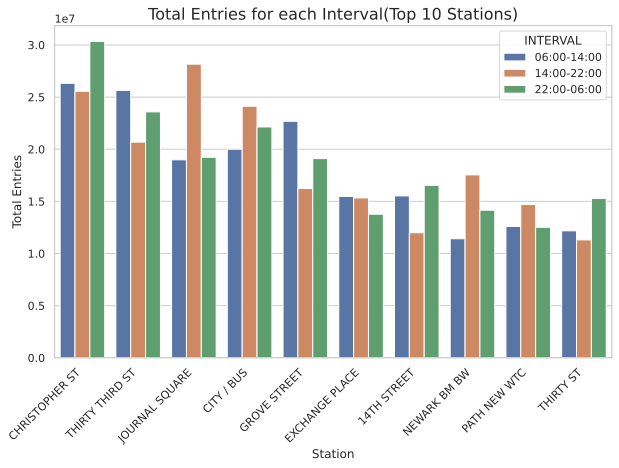

In [86]:
plt.figure(figsize=(10,6))
sns.set_style("whitegrid")


chart = sns.barplot(x='STATION', y='ENTRIES', data=merged_station2, hue='INTERVAL', palette="deep")
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')

chart.set(xlabel='Station', ylabel='Total Entries', title = 'Total Entries for each Interval(Top 10 Stations)')

plt.title('Total Entries for each Interval(Top 10 Stations)', fontsize=16)
;